# <center>Rozpoznawanie różnych odpadów za pomocą sieci konwolucyjnej</center>

## 1.Wstęp


Notebook ten ma na celu przedstawienie modelu bazującego na CNN, mającego rozpoznawać różne typy odpadów na podstawie zdjęć. Powstał on w celach edukacyjnych, więc jedynym założeniem tego projektu było stworzenie tego modelu od początku do końca wraz ze zbieraniem danych i augumentacją
(o których tutaj nie będzie mowa) aż do kompletnego modelu, który ma jak największą możliwą celność.


## 2.Dane


O ile nie będziemy wchodzili w szczegóły odnośnie tego w jaki sposób dane były zbierane, to jednak warto wspomnieć jakie dane mamy do dyspozycji. Jako, że model ma na celu rozpoznawanie różnych rodzajów odpadów, założyliśmy, że będą to 4 kategorie:
<ul>
    <li>Makulatura</li>
    <li>Plastik</li>
    <li>Szkło</li>
    <li>Inne - odpady nie pasujące do żadnej z pozostałych kategorii</li>
</ul>

Musimy jednak storzyć 2 oddzielne zbiory danych - testowy i treningowy, biorąc pod uwagę ilość zdjęć w każdej kategorii, na potrzeby tego modelu podzieliłem dane w następujący sposób:

##### Zbiór testowy:
<ul>
    <li>Makulatura - 4578 zdjęć</li>
    <li>Plastik - 2910 zdjęć</li>
    <li>Szkło - 3306 zdjęć</li>
    <li>Inne - 912 zdjęć</li>
</ul>

##### Zbiór treningowy:
<ul>
    <li>Makulatura - 10902 zdjęcia</li>
    <li>Plastik - 10674 zdjęcia</li>
    <li>Szkło - 10602 zdjęcia</li>
    <li>Inne - 3432 zdjęcia</li>
</ul>

Głownie chciałem podzielić zbiór mniej więcej na 80% zdjęć do zbioru treningowego i 20% do zbioru testowego. Oczywiście ważne jest również aby w zbiorze treningowym było około tyle samo zdjęć w każdej kategorii.
Jednak biorąc pod uwagę, że ogólna liczba zdjęć w każdej kategorii nie jest równa, wymagane były kompromisy. Przez to jak widać w kategorii "inne" mamy o wiele mniej zdjęć niż w pozostałych kategoriach, z kolei w kategorii "makulatura" mamy ich zdecydowanie więcej, dlatego nadwyżka została wrzucona do zbioru testowego. Biorąc pod uwagę nierówność zdjęć w zbiorze testowym bardzo ważne jest, aby podczas testowania nie tylko śledzić ogólną celność modelu lecz jak on się sprawdza dla poszczególnych kategorii.

# 3.Kod

Mamy za sobą objaśnienie danych przejdźmy zatem do kodu.

Na początku zapiszmy sobie wszystkie potrzebne nam importy jak oraz zdefiniujmy zmienne odpowiadające nam za ścieżki do naszych danycyh:

In [58]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os.path as path

training_root = "D:\Data\Trainset\\"
test_root = "D:\Data\Testset\\"
classes = ['Inne', 'Makulatura', 'Plastik', 'Szklo']
model_path = "model.pt"

Lista <b>'classes'</b> przechowuje nam nazwy poszczególnych kategorii, które będą klasyfikowane, z kolei <b>'model_path'</b> będzie nam potrzebna do zapisywania utworzonego modelu bądź odczytywaania tego wcześniej zapisanego.

Następną rzeczą którą musimy zrobić to załadować dane:

In [59]:
train_set = torchvision.datasets.ImageFolder(root=training_root,
                                             transform=transforms.ToTensor())
training_loader = torch.utils.data.DataLoader(train_set, batch_size=8,
                                              shuffle=True, num_workers=4)
test_set = torchvision.datasets.ImageFolder(root=test_root,
                                            transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8,
                                          shuffle=True, num_workers=4)

Jak możemy wyżej zaobserwować, aby załadować potrzebne nam zdjęcia użyłem <b><a href="https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder">ImageFoldera</a></b>, aby jednak działał on poprawnie konieczne jest utworzenie odpowiedniej struktury katalogów:
 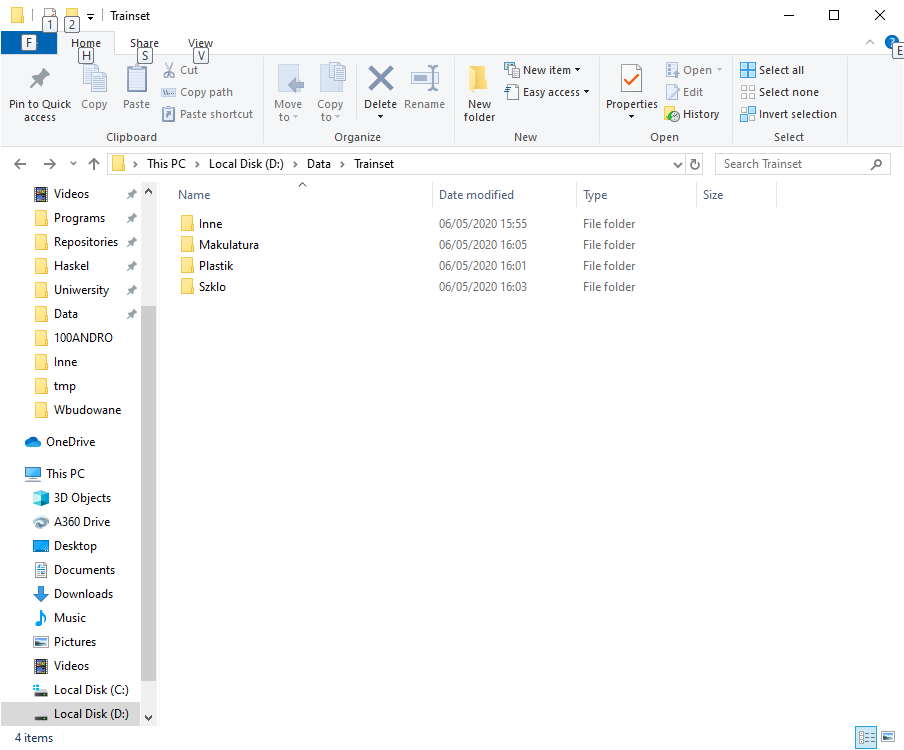

Jednak, aby w wygodny sposób przejść przez te wszystkie dane potrzebny nam jest <b><a href="https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader">DataLoader</a></b>. Warto wzróć uwagę na to, że ustawiamy jego wartość <b>shuffle</b> na <b>True</b>. Musimy tak zrobić, aby nasz zbiór danych miał losową kolejność zdjęć. przez co nasze uczenie będzie bardziej uogólnione i unikniemy zbędnego overfittingu.

Jako, że mamy załadowane zdjęcia spróbujmy wyświetlić kilka przykładów:


Using matplotlib backend: TkAgg
Szklo Plastik Makulatura Plastik Plastik Szklo Makulatura Plastik


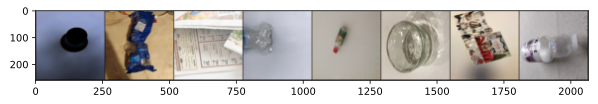

In [64]:
%matplotlib
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images
dataiter = iter(training_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

Nasze dane są już załadowane, więc najwyższy czas aby zająć się naszą siecią.
Jednak zanim zaczniemy potrzebne są nam dodatkowe importy:

In [61]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

Mamy importy, zacznijmy więc od konstruktora.

In [62]:
class Net(nn.Module):
    def __init__(self, lr, epochs, classes,
                 training_data_loader, test_data_loader):
        super(Net, self).__init__()
        # initializing variables
        self.lr = lr
        self.epochs = epochs
        self.classes = classes
        self.training_data_loader = training_data_loader
        self.test_data_loader = test_data_loader

No dobra, objaśnijmy sobie, co to wszystko oznacza:
    <ul>
        <li>lr - learning rate, hyperparametr który za to jak bardzo wagi
        naszego modelu są aktualizowane podczas każdego kroku.
        Za mały, może sprawić, że model utknie w pewnym miejscu i przestanie się uczyć. Z kolei za duży sprawi, że model szybko dojdzie do rozwiązania, które nie jest optymalne.</li>
    <li>epochs - ilość epok, którą chcemy użyć tzn. ile razy chcemy aby model uczył się na danym zbiorze danych</li>
    <li>classes - kategorie do których należą nasze zdjęcia</li>
    <li>training_data_loader - DataLoader ze zbiorem treningowym</li>
    <li>test_data_loader - DataLoader ze zbiorem testowym</li>
    </ul>
    To jednak tylko zmienne przekazywane przez konstruktor:

In [63]:
        self.loss_history = []
        self.acc_history = []
        self.device = torch.device(
            'cuda:0' if torch.cuda.is_available() else 'cpu')
        print(self.device)

NameError: name 'self' is not defined

Dwie zadeklarowane listy będą służyć do śledzenia dokładności i straty podczas trenowania naszego modelu. Chcemy również przyśpieszyć trening poprzez użycie karty graficznej(o ile to możliwe).